In [1]:
#import libraries

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#import data from recipes
#Example: nature article. We used couple of personal datasets. But you can add whatever source you want: hand-, api-, parser-builded cookbooks.

In [4]:
kit_data = pd.read_csv('_data_/_small_data_/srep00196-s3.csv', skiprows=[0,1,2,3], header=None, sep=';')

kit_data[1] = kit_data[0].apply(lambda x: str(x).split(',')[0])
kit_data[0] = kit_data[0].apply(lambda x: (str(x).split(',')[1:]))

kit_data.columns = ['ingredients', 'kitchen']

In [5]:
kit_data.head()

,ingredients,kitchen
0,"[chicken, cinnamon, soy_sauce, onion, ginger]",African
1,"[cane_molasses, ginger, cumin, garlic, tamarin...",African
2,"[butter, pepper, onion, cardamom, cayenne, gin...",African
3,"[olive_oil, pepper, wheat, beef, onion, cardam...",African
4,"[honey, wheat, yeast]",African


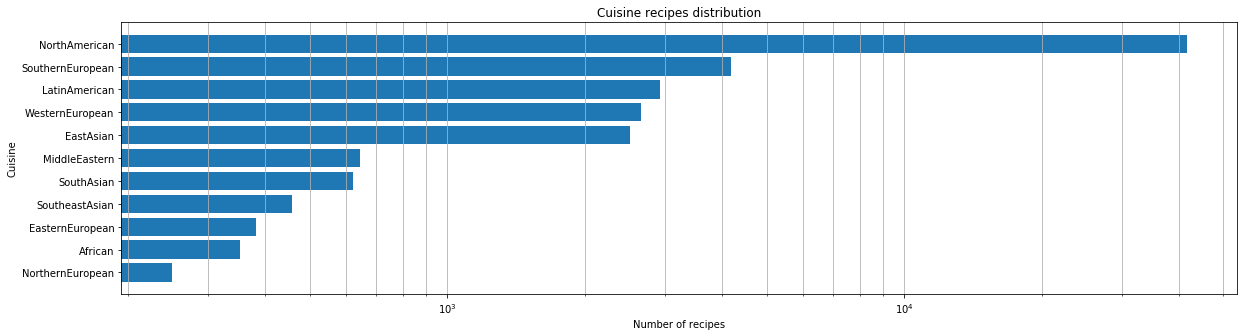

In [6]:
n_recipes = kit_data['kitchen'].value_counts()
cuisines = n_recipes.keys()

fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Cuisine recipes distribution')
ax.barh(y=cuisines, width=n_recipes, log=True)
ax.grid(axis='x', which='both')
ax.invert_yaxis()
ax.set_xlabel('Number of recipes')
ax.set_ylabel('Cuisine');

In [7]:
from collections import Counter

In [8]:
ingr_freqs = dict()

for cuisine in cuisines:
    ingr_freqs[cuisine] = Counter()

for i in kit_data.index:
    for ingr in kit_data.loc[i, 'ingredients']:
        ingr_freqs[kit_data.loc[i, 'kitchen']][ingr]+=1
        
ingr_freqs = pd.DataFrame.from_records(ingr_freqs)

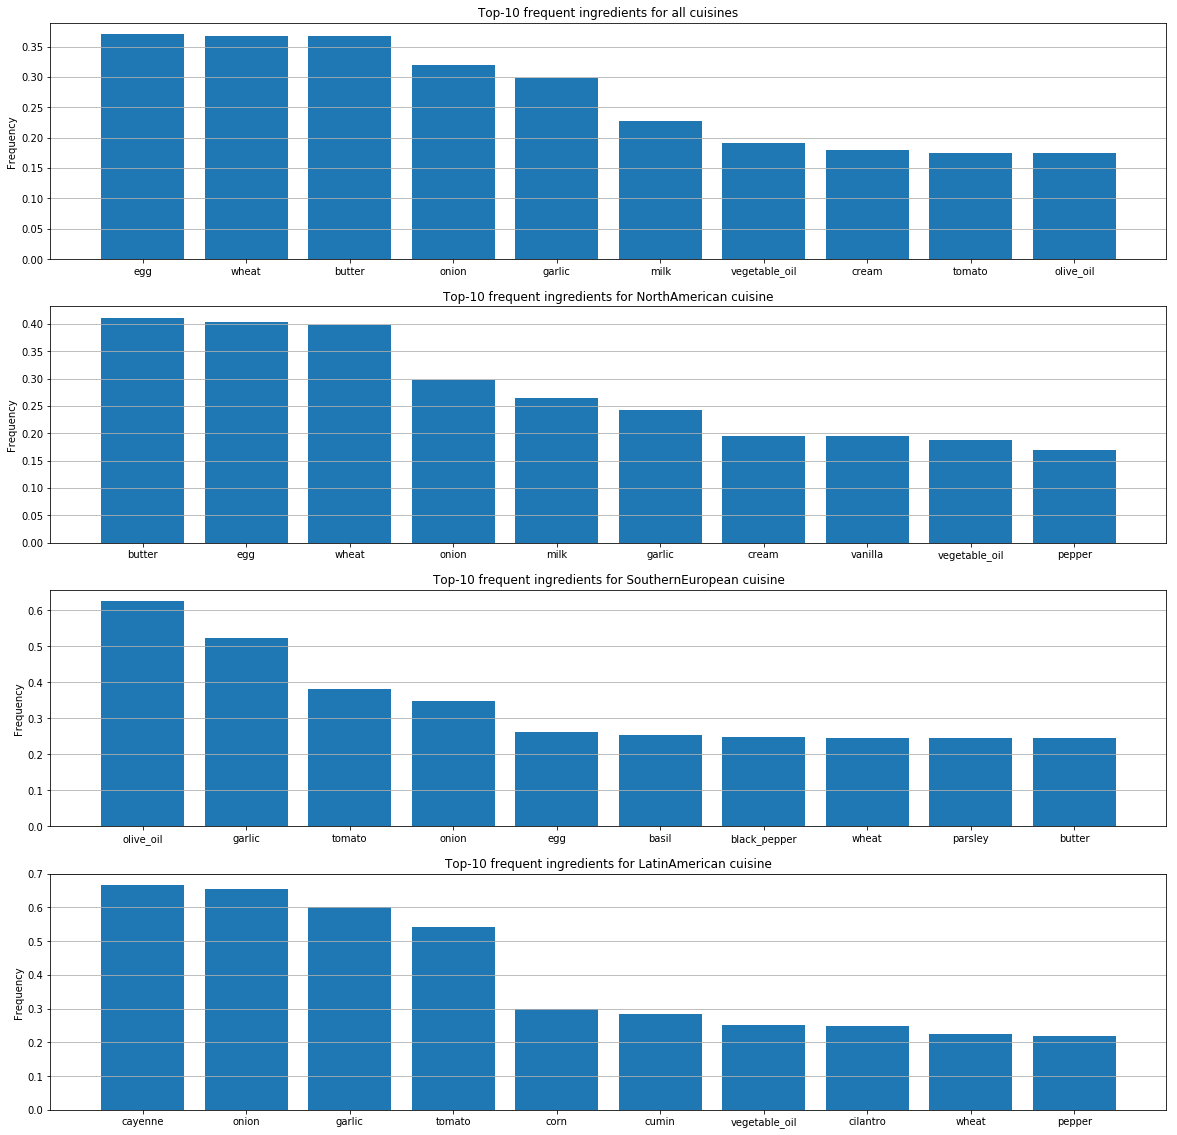

In [9]:
fig, axes = plt.subplots(nrows=4, figsize=(20,20))


most_freq = ingr_freqs.sum(axis=1).sort_values(ascending=False)[:10]

axes[0].set_title('Top-10 frequent ingredients for all cuisines')
axes[0].bar(x=most_freq.keys(), height=most_freq/n_recipes.sum())
axes[0].grid(axis='y')
axes[0].set_ylabel('Frequency');

for cuisine, ax in zip(['NorthAmerican', 'SouthernEuropean', 'LatinAmerican'], axes[1:]):
    most_freq = ingr_freqs[cuisine].sort_values(ascending=False)[:10]

    ax.set_title('Top-10 frequent ingredients for {} cuisine'.format(cuisine))
    ax.bar(x=most_freq.keys(), height=most_freq/n_recipes[cuisine])
    ax.grid(axis='y')
    ax.set_ylabel('Frequency');

In [10]:
#Personal nature-like dataset includes types of dishes, for example: sandwiches, deserts, fish etc.

In [11]:
pt1 = np.load('_data_/_recipes_/part1.npy')
cat_data = pd.DataFrame.from_records(pt1, exclude=['directions', 'servings'])
cat_data['ingredients'] = cat_data['ingredients'].apply(lambda info: np.array(info)[:, 2])

In [12]:
cat_data.head()

,categories,ingredients
0,"[desserts, chocolate]","[butter, butter, white, egg, milk, vanilla, fl..."
1,"[beans-and-peas, whole-grains, gourmet, vegan]","[bulgur, water, vegetable_oil, lemon_juice, sa..."
2,"[desserts, fruits, easter]","[butter, sugar, eggs, flour, milk, corn, lemon..."
3,[chicken],"[potato, chicken_broth, black_pepper, olive_oi..."
4,"[chicken, pasta-and-noodles, soups-stews-and-c...","[chicken_broth, chicken, corn, chicken, chicke..."


In [13]:
cat_count = Counter()
for i in cat_data.index:
    for cat in cat_data.loc[i, 'categories']:
        cat_count[cat]+=1
print('Found {} categories'.format(len(cat_count)))

Found 77 categories


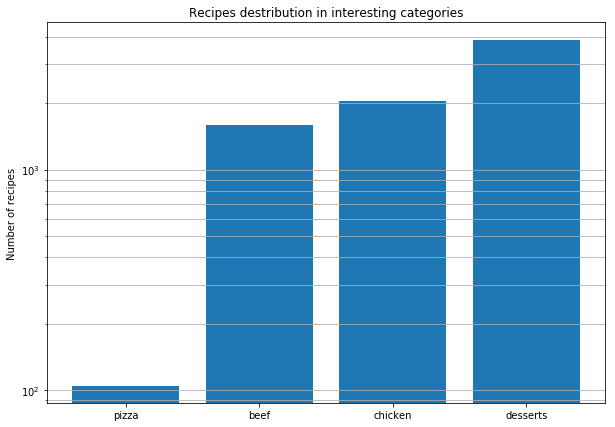

In [14]:
interesting_cats = ['pizza', 'beef', 'chicken', 'desserts']
n_recs_interesting = [cat_count[cat] for cat in interesting_cats]

plt.figure(figsize=(10,7))
plt.title('Recipes destribution in interesting categories')
plt.bar(x=interesting_cats, height=n_recs_interesting, log=True)
plt.grid(axis='y', which='both')
plt.ylabel('Number of recipes');

In [15]:
pizza_recipes = cat_data[cat_data['categories'].apply(lambda categories: 'pizza' in categories)]

pizza_ingrs_count = Counter()
for i in pizza_recipes.index:
    for ingr in pizza_recipes.loc[i, 'ingredients']:
        pizza_ingrs_count[ingr]+=1

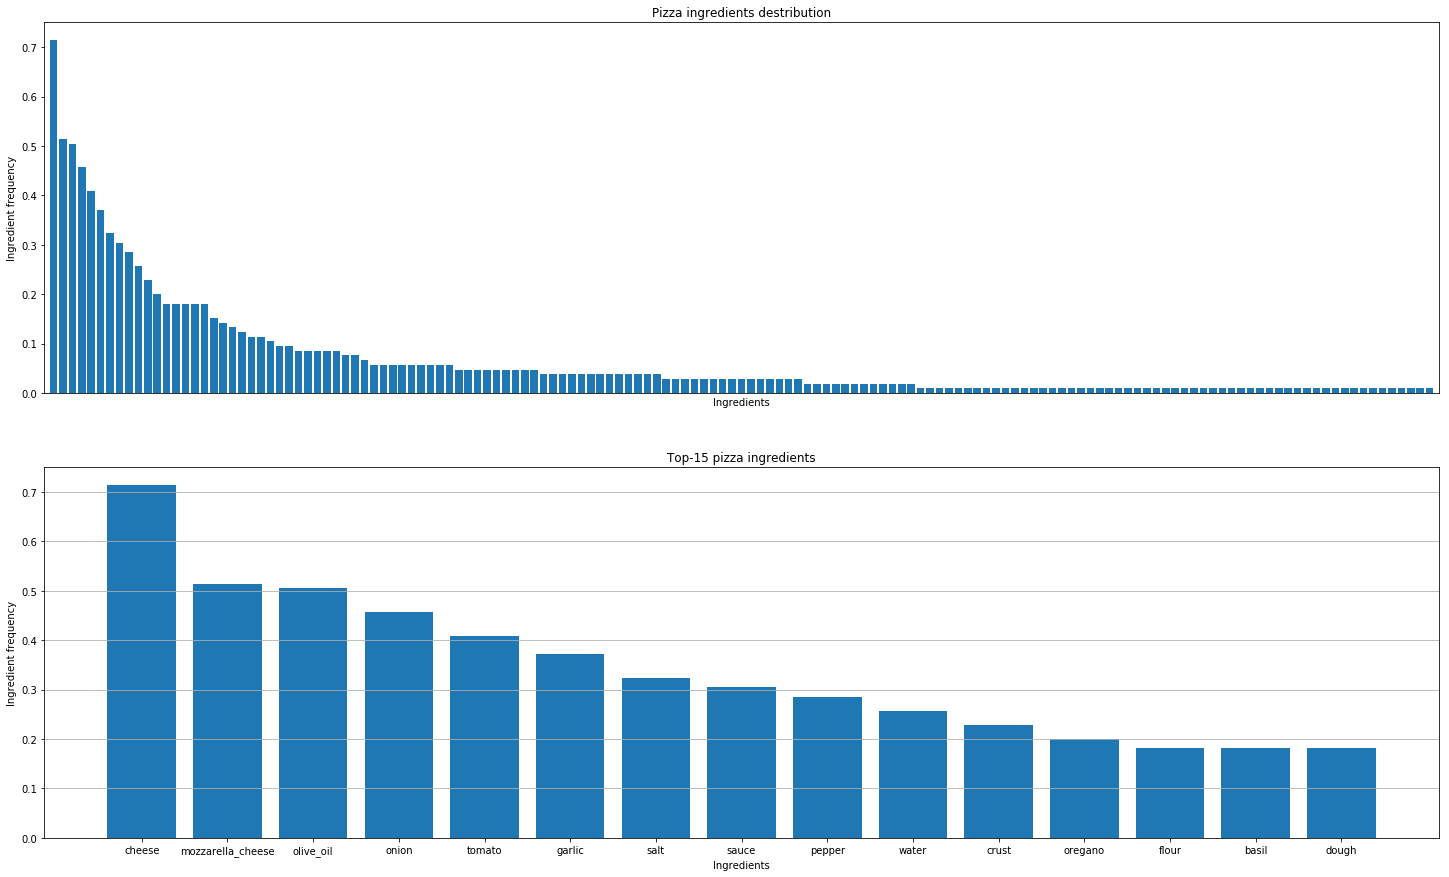

In [16]:
pizza_ingrs = pizza_ingrs_count.keys()
common_pizza_ingrs = pizza_ingrs_count.most_common()

fig, axes = plt.subplots(nrows=2, figsize=(25,15))
axes[0].set_title('Pizza ingredients destribution')
axes[0].bar(height=[x[1]/len(pizza_recipes) for x in common_pizza_ingrs], x=np.arange(len(pizza_ingrs)))
axes[0].set_xlim([-1, len(pizza_ingrs)])
axes[0].set_xticks([])
axes[0].set_ylabel('Ingredient frequency')
axes[0].set_xlabel('Ingredients')

common_pizza_ingrs = common_pizza_ingrs[:15]
axes[1].set_title('Top-15 pizza ingredients')
axes[1].bar(height=[x[1]/len(pizza_recipes) for x in common_pizza_ingrs], x=[x[0] for x in common_pizza_ingrs])
axes[1].grid(axis='y')
axes[1].set_ylabel('Ingredient frequency')
axes[1].set_xlabel('Ingredients');

In [17]:
#import molecular dependencies

In [18]:
mol_data = pd.read_csv('_data_/_small_data_/srep00196-s2.csv', skiprows=[0,1,2,3], header=None)
mol_data.columns = ['ingr1', 'ingr2', 'connect']

In [19]:
mol_data.head()

,ingr1,ingr2,connect
0,black_sesame_seed,rose_wine,3
1,fennel,wild_berry,5
2,comte_cheese,grape,57
3,nira,raw_beef,1
4,corn_mint_oil,parsnip_fruit,2


In [20]:
#import word2vec

In [21]:
#It is necessary to convert ingredients to vectors with saving sence. The taste intuitions like lemon is similar to lime and lemon juice should work.
#We used ... algorithm to solve this problem <refrence>. Results are below.

In [22]:
from _utils_.Ingr2Vec import IngrVectors
from _utils_.Ingr2Vec import default_model as ingr_vectorizer

word2vec = ingr_vectorizer()

In [23]:
cos_sim = lambda a,b: np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [24]:
from itertools import combinations

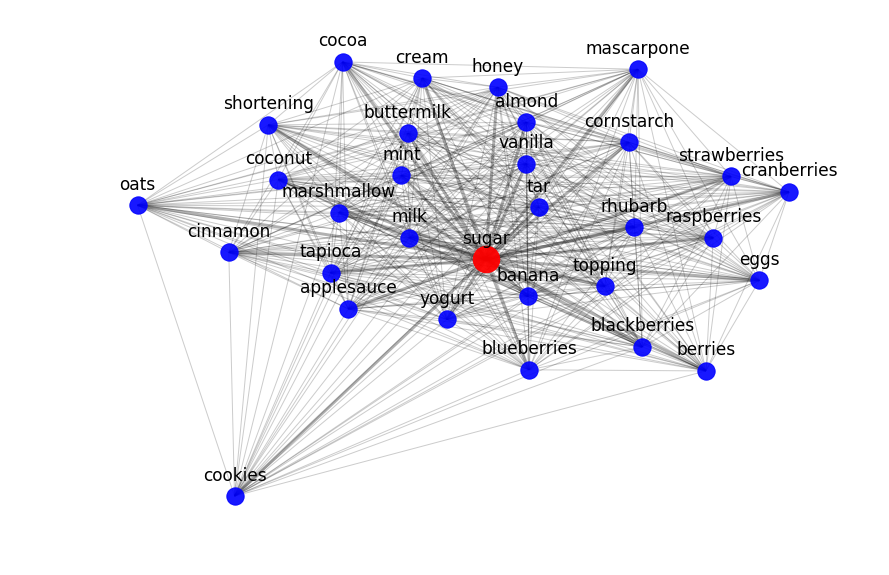

In [53]:
n_neighbors = 30
init_ingr = 'sugar'

plt.figure(figsize=(15,10))

G = nx.Graph()
neighbors = word2vec.nearest_words(init_ingr, n_neighbors)
G.add_node(init_ingr)
for i, (neighbor, dist) in enumerate(neighbors):
    G.add_node(neighbor)
    G.add_edge(init_ingr, neighbor, length=dist)
    
for (neighbor1, _), (neighbor2, _) in combinations(neighbors, 2):
    G.add_edge(neighbor1, neighbor2, 
                   length = cos_sim(word2vec.ingr_vector(neighbor1), word2vec.ingr_vector(neighbor2)))
    
pos = nx.spring_layout(G, weight='length')

nx.draw_networkx_nodes(G, pos, [init_ingr], 
                       node_color='red', node_size=700, alpha=0.95)
nx.draw_networkx_nodes(G, pos, list(G.nodes)[1:],
                       node_color='blue', node_size=300, alpha=0.9)

nx.draw_networkx_edges(G, pos, [(x, y) for x,y in G.edges if x==init_ingr],
                       width=3, alpha=.3)

nx.draw_networkx_edges(G, pos, [(x, y) for x,y in G.edges if x!=init_ingr],
                       width=1, alpha=.2)

nx.draw_networkx_labels(G, {name: loc+np.array([0, .075]) for name, loc in pos.items()}, 
                        {name: name for name in G.nodes},
                        font_size=17)


x_min, y_min = np.array(list(pos.values())).min(0)
x_max, y_max = np.array(list(pos.values())).max(0)

plt.ylim(y_min-.2, y_max+.2)
plt.xlim(x_min-.2, x_max+.2)

plt.axis('off');

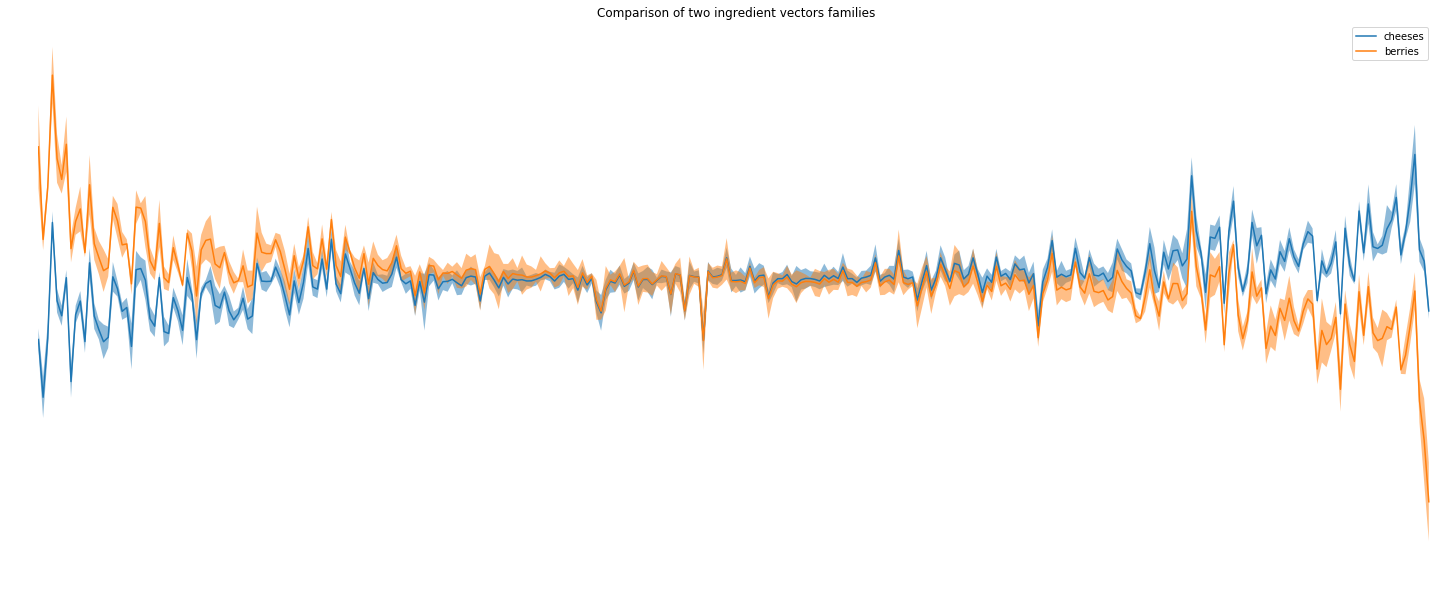

In [41]:
similar_ingrs_1 = ['cheese', 'gruyere', 'mozzarella', 'parmesan', 'cheddar', 'provolone', 'romano', 'fontina', 'reggiano']
similar_ingrs_2 = ['raspberry', 'blackberry', 'blueberry', 'strawberry']

means = []
stds = []

for sim_ingrs in [similar_ingrs_1, similar_ingrs_2]:
    sim_vectors = np.array([word2vec.ingr_vector(ingr) for ingr in sim_ingrs])
    means.append(sim_vectors.mean(axis=0))
    stds.append(sim_vectors.std(axis=0))

means_sorted = np.zeros_like(means)
stds_sorted = np.zeros_like(stds)

for i, (mean1, mean2, std1, std2) in enumerate(sorted(zip(means[0], means[1], stds[0], stds[1]), key=lambda x: x[0]-x[1])):
    means_sorted[:,i] = mean1, mean2
    stds_sorted[:,i] = std1, std2
    
plt.figure(figsize=(25,10))
plt.title('Comparison of two ingredient vectors families')

for mean, std, name in zip(means_sorted, stds_sorted, ['cheeses', 'berries']):
    plt.plot(mean, label=name)
    plt.fill_between(np.arange(len(mean)), mean+std, mean-std, alpha=.5)

plt.legend()
plt.xlim(0, len(mean))
plt.axis('off');